In [2]:
# base
import requests
import datetime
import json
import time
import os

# finance
# import yfinance as yf
import apimoex as moex
import numpy as np
import pandas as pd
from typing import NamedTuple

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# metrics
## classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
## regression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# data manipulation
from sklearn.model_selection import train_test_split

SEED = 20240704

---
Working with API MOEX

In [3]:
intervals = {'1m': 1,
             '10m': 10,
             '1h': 60,
             '1d': 24,
             '1w': 7,
             '1_month': 31,
             '1_quater': 4}

In [4]:
def get_candles_data(ticker: str, interval: str, start_date = None, end_date=None) -> pd.DataFrame:
    """
        The function returns historical candles data fro a given ticker within specific time intervals and frequency

        Arguments:
            ticker, str - a ticker name
            interval, str - a data frequency, for example 1h means historical data contains candles with 1h time difference
            start_date, str - a historical data start date in a format 'yyyy-mm-dd', if None, takes the first occurence date
            end_date, str - a historical data end point date in a format 'yyyy-mm-dd', if None, takes the last occurance date

        Returns
            df, pd.DataFrame - a dataframe with historical candles data, containing Open, Close, High, Low, Volume, Value data columns,
                                provided by API MOEX
    """
    # TODO обрабатывать валидность дат
    with requests.Session() as session:
        data = moex.get_market_candles(session, security=ticker, interval=intervals[interval], start=start_date, end=end_date)

    df = pd.DataFrame(data)

    return df

In [5]:
sber = get_candles_data('SBER', '1d', '2022-01-01', '2024-07-02')

In [6]:
sber.describe()

,open,close,high,low,value,volume
count,614.000000,614.000000,614.000000,614.000000,6.140000e+02,6.140000e+02
mean,215.051775,214.997231,217.579886,212.089332,1.315942e+10,6.389580e+07
std,70.641098,70.653025,70.561776,70.700733,1.796658e+10,8.429680e+07
min,96.550000,101.500000,106.770000,89.590000,1.504731e+09,5.980690e+06
25%,137.017500,136.912500,138.595000,135.212500,6.035559e+09,2.938891e+07
50%,241.250000,240.530000,242.995000,237.380000,8.679805e+09,4.434563e+07
75%,273.630000,273.702500,275.892500,270.962500,1.334358e+10,6.764444e+07
max,327.870000,328.370000,329.300000,326.820000,2.385837e+11,1.084508e+09


In [7]:
sber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   begin   614 non-null    object 
 1   open    614 non-null    float64
 2   close   614 non-null    float64
 3   high    614 non-null    float64
 4   low     614 non-null    float64
 5   value   614 non-null    float64
 6   volume  614 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 33.7+ KB


In [8]:
sber.columns

Index(['begin', 'open', 'close', 'high', 'low', 'value', 'volume'], dtype='object')

In [9]:
# преобразуем колонку begin в тип datetime и сделаем индексом
sber.begin = pd.to_datetime(sber.begin)
sber.set_index('begin', inplace=True)
sber

,open,close,high,low,value,volume
begin,,,,,,
2022-01-03,295.90,305.47,305.50,294.34,1.511647e+10,50183170
2022-01-04,305.51,304.24,310.10,301.63,1.627717e+10,53270410
2022-01-05,303.72,287.01,304.26,287.00,2.074094e+10,70017630
2022-01-06,286.60,293.92,295.10,281.00,2.312860e+10,79380930
2022-01-10,295.52,291.69,298.88,288.68,1.975769e+10,67426550
...,...,...,...,...,...,...
2024-06-26,320.10,324.55,324.56,319.80,1.372147e+10,42491110
2024-06-27,324.80,327.16,327.83,322.63,1.522113e+10,46771370
2024-06-28,327.87,327.15,329.30,325.80,1.325036e+10,40451800


---
Visualization

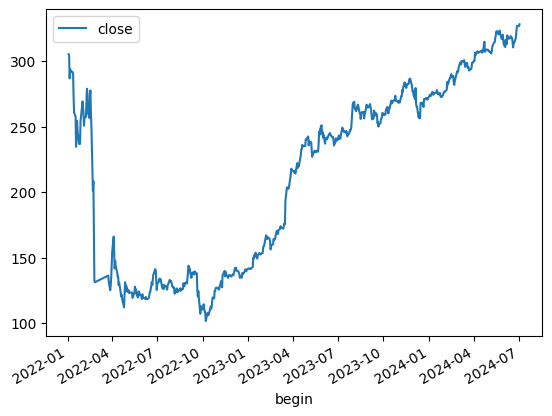

In [10]:
sber.close.plot()
# sber.open.plot()
plt.legend()
plt.show()

 ---


In [11]:
path_to_tickers = './MOEX_tickers.csv'

In [12]:
tickers_df = pd.read_csv(path_to_tickers, sep=';', header=None)

In [13]:
tickers_df = tickers_df[tickers_df.columns[:2]]
tickers_df.columns = ['ticker', 'short name']
tickers_df

,ticker,short name
0,SNGS,Сургнфгз
1,GAZP,ГАЗПРОМ ао
2,MRKC,РоссЦентр
3,LKOH,ЛУКОЙЛ
4,MTSS,МТС-ао
...,...,...
243,ASTR,Астра ао
244,ASSB,АстрЭнСб
245,ARSA,Арсагера
246,AMEZ,АшинскийМЗ


In [14]:
def get_listing_date(ticker: str):
    """
        column `name` -> issuedate
        value -> 

        index = 8

        return date if the stock issue
    """
    with requests.Session() as session:
        descr = pd.DataFrame(moex.find_security_description(session = session, security = ticker)).set_index('name')

    return descr.loc['ISSUEDATE'].value


def get_issue_size(ticker: str) -> np.ndarray:
    pass

def get_listing_level(ticker: str) -> np.ndarray:
    pass


def get_ticker_description(ticker: str):
    """
        # TODO optimize params choice
    """

    with requests.Session() as session:
        descr = pd.DataFrame(moex.find_security_description(session = session, security = ticker)).set_index('name')
    
    listing_date = descr.loc['ISSUEDATE'].value
    issue_size = descr.loc['ISSUESIZE'].value
    listing_level = descr.loc['LISTLEVEL'].value

    return listing_date, issue_size, listing_level

In [15]:
get_listing_date('SBER')

'2007-07-20'

In [16]:
issue_dates = tickers_df.ticker.apply(lambda x: get_listing_date(x))

In [17]:
tickers_df['issue_date'] = pd.to_datetime(issue_dates)

In [18]:
tickers_df

,ticker,short name,issue_date
0,SNGS,Сургнфгз,2005-01-11
1,GAZP,ГАЗПРОМ ао,2006-01-23
2,MRKC,РоссЦентр,2008-05-21
3,LKOH,ЛУКОЙЛ,2003-08-20
4,MTSS,МТС-ао,2004-02-11
...,...,...,...
243,ASTR,Астра ао,2023-10-13
244,ASSB,АстрЭнСб,2005-09-16
245,ARSA,Арсагера,2008-04-07
246,AMEZ,АшинскийМЗ,2008-08-28


In [20]:
# listing_date, issue_size, listing_level = get_ticker_description()
datas = tickers_df.ticker.apply(lambda x: get_ticker_description(x))

In [21]:
listing_dates, issue_sizes, listing_levels = [], [], []

for listing_date, issue_size, listing_level in datas:
    listing_dates.append(listing_date)
    issue_sizes.append(issue_size)
    listing_levels.append(listing_level)

In [22]:
tickers_df['issue_size'] = issue_sizes
tickers_df['listing_level'] = listing_levels

In [23]:
tickers_df

,ticker,short name,issue_date,issue_size,listing_level
0,SNGS,Сургнфгз,2005-01-11,35725994705,2
1,GAZP,ГАЗПРОМ ао,2006-01-23,23673512900,1
2,MRKC,РоссЦентр,2008-05-21,42217941468,2
3,LKOH,ЛУКОЙЛ,2003-08-20,692865762,1
4,MTSS,МТС-ао,2004-02-11,1998381575,1
...,...,...,...,...,...
243,ASTR,Астра ао,2023-10-13,210000000,2
244,ASSB,АстрЭнСб,2005-09-16,773900078,3
245,ARSA,Арсагера,2008-04-07,123817165,3
246,AMEZ,АшинскийМЗ,2008-08-28,498454822,3


In [24]:
with requests.Session() as session:
        descr = pd.DataFrame(moex.find_security_description(session = session, security = 'SBER')).set_index('name')

descr

,title,value
name,,
SECID,Код ценной бумаги,SBER
NAME,Полное наименование,Сбербанк России ПАО ао
SHORTNAME,Краткое наименование,Сбербанк
ISIN,ISIN код,RU0009029540
REGNUMBER,Номер государственной регистрации,10301481B
ISSUESIZE,Объем выпуска,21586948000
FACEVALUE,Номинальная стоимость,3
FACEUNIT,Валюта номинала,SUR
ISSUEDATE,Дата начала торгов,2007-07-20


In [25]:
issue_date_earlier_2022 = tickers_df.issue_date.apply(lambda x: True if x.year < 2022 else False)
filtered_tickers_df = tickers_df.where(issue_date_earlier_2022).dropna().sort_values(by='issue_date')

In [26]:
filtered_tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 21 to 175
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ticker         229 non-null    object        
 1   short name     229 non-null    object        
 2   issue_date     229 non-null    datetime64[ns]
 3   issue_size     229 non-null    object        
 4   listing_level  229 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 10.7+ KB


In [27]:
filtered_tickers_df.to_csv('./tickers_list.csv')

In [28]:
get_candles_data('SBER', '1h', '2022-01-01', '2022-07-02')

,begin,open,close,high,low,value,volume
0,2022-01-03 06:00:00,295.90,295.90,295.90,295.90,7.962669e+06,26910
1,2022-01-03 07:00:00,295.90,295.10,296.10,294.34,3.108796e+08,1053730
2,2022-01-03 08:00:00,295.09,296.55,296.80,294.90,3.793610e+08,1282050
3,2022-01-03 09:00:00,296.55,296.60,296.95,295.86,3.449864e+08,1164060
4,2022-01-03 10:00:00,296.57,300.25,301.20,296.45,2.852590e+09,9537250
...,...,...,...,...,...,...,...
1320,2022-07-01 14:00:00,130.91,130.45,131.44,130.23,5.235922e+08,4001630
1321,2022-07-01 15:00:00,130.45,130.69,130.88,130.09,3.028823e+08,2320410
1322,2022-07-01 16:00:00,130.69,131.63,132.00,130.66,6.875613e+08,5230960
1323,2022-07-01 17:00:00,131.63,130.75,131.78,130.62,3.577043e+08,2725390


In [29]:
START_DATE = '2022-07-01'
END_DATE = '2024-07-01'
INTERVAL = '1d'

candles_df = pd.DataFrame()

for ticker in filtered_tickers_df.ticker.values:
    _df = get_candles_data(ticker, INTERVAL, START_DATE, END_DATE)
    _df['ticker_name'] = ticker
    if not candles_df.empty:
        candles_df = pd.concat([candles_df, _df])
    else:
        candles_df = _df 
        

In [30]:
data = {}
for ticker in filtered_tickers_df.ticker.values:
    try:
        _df = get_candles_data(ticker, INTERVAL, START_DATE, END_DATE)
        _df.begin = pd.to_datetime(_df.begin)
        _df.set_index('begin', inplace=True)
        data[ticker] = _df
    except Exception as e:
        print(f'Exception with ticker = {ticker}')
        print(e.args)

Exception with ticker = ACKO
("'DataFrame' object has no attribute 'begin'",)


In [31]:
def from_ticker_to_features(data: pd.DataFrame) -> dict:
    """
        converts dict of dataFrames for each tocker by features 
        into a dict of dataFrames for each feature by tickers

        Arguments:
            data, dict - dictionary of candles in a format: {symbol: candles}

        Returns:
            output, dict - dictionary of tickers data by feature
            in a format: {feature: tickers}
    """
    data_merged = pd.concat(data, axis=1).swaplevel(0, 1, axis=1).sort_index(axis=1)
    feature_names = data_merged.columns.get_level_values(0).unique()
    features = {}
    for feature_name in feature_names:
        features[feature_name] = data_merged[feature_name]
    return features

In [32]:
tickers_features = from_ticker_to_features(data)

In [ ]:
tickers_features.keys()

In [33]:
close_df = tickers_features['close']
open_df = tickers_features['open']
low_df = tickers_features['low']
high_df = tickers_features['high']
value_df = tickers_features['value']

In [ ]:
close_df

In [33]:
close_df.to_csv('./close.csv')
open_df.to_csv('./open.csv')
low_df.to_csv('./low.csv')
high_df.to_csv('./high.csv')
value_df.to_csv('./value.csv')

In [41]:
tickers_df.listing_level = tickers_df.listing_level.astype('int')
tickers_df.issue_size = tickers_df.issue_size.astype('int')

In [42]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ticker         248 non-null    object        
 1   short name     248 non-null    object        
 2   issue_date     248 non-null    datetime64[ns]
 3   issue_size     248 non-null    int64         
 4   listing_level  248 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.8+ KB


---

In [43]:
tickers_lvl1 = tickers_df[tickers_df.listing_level == 1].ticker

In [44]:
tickers_lvl1.size

59

In [45]:
ticker = tickers_lvl1.iloc[1]

In [46]:
ticker

'LKOH'

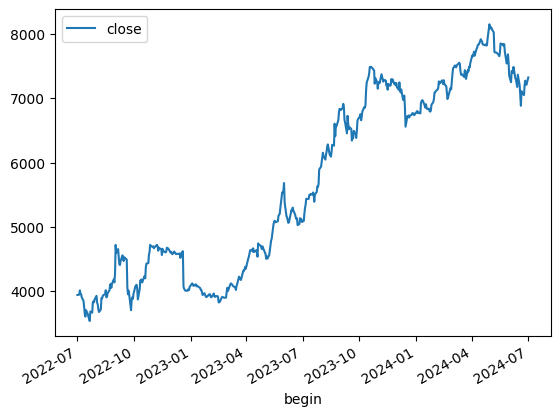

In [47]:
data[ticker].close.plot()

plt.legend()
plt.show()

In [48]:
def returns_vec(df: pd.DataFrame) -> np.ndarray:
    return (df.close / df.close.shift() - 1)

<Axes: xlabel='begin'>

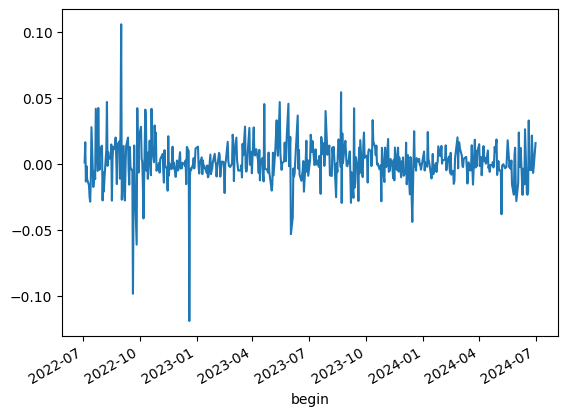

In [49]:
returns_vec(data[ticker]).plot()

In [43]:
# df = pd.DataFrame({'returns': returns_vec(data[ticker]).values,
#                    'open': })

In [50]:
returns_lkoh = pd.DataFrame(returns_vec(data[ticker]))

In [51]:
returns_lkoh

,close
begin,
2022-07-01,NaN
2022-07-04,0.001395
2022-07-05,0.016584
2022-07-06,-0.013200
2022-07-07,-0.001514
...,...
2024-06-25,0.021627
2024-06-26,0.009856
2024-06-27,-0.006598


In [52]:
window = 5

x, y = [], []
dates = []
prev_dates = []

for sub_df in returns_lkoh.dropna().rolling(window=6):
    if sub_df.size < 6:
        continue
    x.append(sub_df.close.values[:-1])
    y.append(sub_df.close.values[-1])
    dates.append(sub_df.reset_index().begin.values[-1])
    prev_dates.append(sub_df.reset_index().begin.values[-2])

In [53]:
x = np.array(x)
y = np.array(y)

In [54]:
x.shape, y.shape, len(dates)

((503, 5), (503,), 503)

In [55]:
x[0], x[1]

(array([ 0.00139452,  0.01658438, -0.0132005 , -0.00151439, -0.01137513]),
 array([ 0.01658438, -0.0132005 , -0.00151439, -0.01137513, -0.01598057]))

In [56]:
y[0], y[1]

(np.float64(-0.015980567629762188), np.float64(-0.025074704430297468))

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [58]:
x_train.shape, y_train.shape

((402, 5), (402,))

In [59]:
x_test.shape, y_test.shape

((101, 5), (101,))

---

In [60]:
class Results(NamedTuple):
    model_name: str
    model_params: str
    ticker_name: str
    mse: float
    accuracy: float
    predicted_vec: np.ndarray
    

In [61]:
results = []

---
Linear Regression model

In [63]:
lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

LinearRegression()

In [64]:
prediction = lin_reg.predict(x_test)

In [65]:
results.append(Results(model_name='LinReg',
                       model_params='',
                       ticker_name=ticker,
                       mse=mean_squared_error(prediction, y_test),
                       accuracy=accuracy_score(np.sign(prediction), np.sign(y_test)),
                       predicted_vec=prediction))

---
KNN

In [66]:
best_model, best_k = ..., None

min_loss = 10**10

for k in range(3, 20, 3):
    _knn = KNeighborsRegressor(n_neighbors=k)
    _knn.fit(x_train, y_train)
    prediction = _knn.predict(x_test)
    loss = mean_squared_error(prediction, y_test)
    if loss < min_loss:
        best_model = _knn
        best_k = k
        min_loss = loss

In [67]:
knn_reg = best_model

In [68]:
prediction = knn_reg.predict(x_test)

results.append(Results(model_name='KNN',
                       model_params=f'k = {k}',
                       ticker_name=ticker,
                       mse = mean_squared_error(prediction, y_test),
                       accuracy=accuracy_score(np.sign(prediction), np.sign(y_test)),
                       predicted_vec=prediction
                      ))

---
Decision Tree Regressor

In [69]:
depthes = [i for i in range(7, 40, 5)]
min_sample_leaf = [i for i in range(1, 7, 2)]
min_sample_split = [i for i in range(2, 9, 2)]

best_params = {}
min_loss = 10**10
best_model = ...

for depth in depthes:
    for leaf in min_sample_leaf:
        for split in min_sample_split:
            
            params = {'max_depth': depth,
                      'min_samples_leaf': leaf,
                      'min_samples_split': split,
                      'random_state': SEED
                     }
            
            _dt = DecisionTreeRegressor(**params)
            _dt.fit(x_train, y_train)
            prediction = _dt.predict(x_test)

            loss = mean_squared_error(prediction, y_test)

            if loss < min_loss:
                best_model = _dt
                best_params = params
                min_loss = loss

In [70]:
dt_reg = best_model

prediction = dt_reg.predict(x_test)

results.append(Results(model_name='DT',
                       model_params=best_params,
                       ticker_name=ticker,
                       mse=mean_squared_error(prediction, y_test),
                       accuracy=accuracy_score(np.sign(prediction), np.sign(y_test)),
                       predicted_vec=prediction
                      ))

In [71]:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 20240704,
 'splitter': 'best'}

In [72]:
min_loss

np.float64(0.00018983993803219478)

---
Random Forest

In [73]:
estimators = [30, 50, 70, 120]
depthes = [i for i in range(7, 40, 5)]
min_sample_leaf = [i for i in range(1, 7, 2)]
min_sample_split = [i for i in range(2, 9, 2)]

best_params = {}
min_loss = 10**10
best_model = ...

for depth in depthes:
    for leaf in min_sample_leaf:
        for split in min_sample_split:
            for estimator in estimators:
            
                params = {'max_depth': depth,
                          'min_samples_leaf': leaf,
                          'min_samples_split': split,
                          'n_estimators': estimator,
                          'random_state': SEED
                         }
                
                _rf = RandomForestRegressor(**params)
                _rf.fit(x_train, y_train)
                prediction = _rf.predict(x_test)
    
                loss = mean_squared_error(prediction, y_test)
    
                if loss < min_loss:
                    best_model = _rf
                    best_params = params
                    min_loss = loss

In [74]:
rf_reg = best_model

prediction = rf_reg.predict(x_test)

results.append(Results(model_name='RF',
                       model_params=best_params,
                       ticker_name=ticker,
                       mse = mean_squared_error(prediction, y_test),
                       accuracy=accuracy_score(np.sign(prediction), np.sign(y_test)),
                       predicted_vec=prediction
                      ))

---
Visualization

In [75]:
models, model_params, ticker_name, mse, acc, predicted_vec = [], [], [], [], [], []

In [76]:
results_df = pd.DataFrame({'model': [res.model_name for res in results],
              'params': [res.model_params for res in results],
              'ticker': [res.ticker_name for res in results],
              'mse': [res.mse for res in results],
              'accuracy': [res.accuracy for res in results]})

In [77]:
results_df.sort_values(['mse', 'accuracy'])

,model,params,ticker,mse,accuracy
0,LinReg,,LKOH,0.000146,0.504950
3,RF,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",LKOH,0.000154,0.554455
1,KNN,k = 18,LKOH,0.000160,0.445545
2,DT,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",LKOH,0.000190,0.534653


In [147]:
results_df.to_csv(path_or_buf='.\metrics.csv')

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_7244\1625153507.py:1: SyntaxWarning: invalid escape sequence '\m'
  results_df.to_csv(path_or_buf='.\metrics.csv')


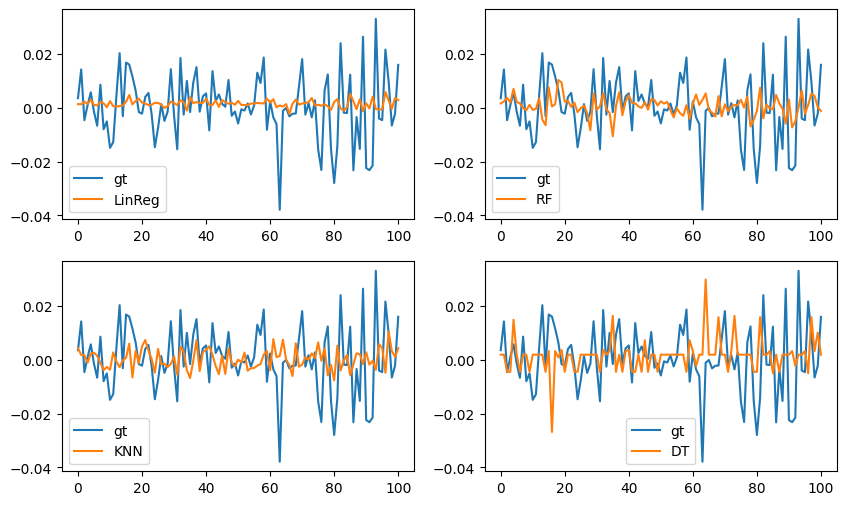

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for idx, model in enumerate(results_df.sort_values(['mse', 'accuracy']).model.values):
    axs[idx//2, idx % 2].plot(y_test, label='gt')
    axs[idx//2, idx % 2].plot([res.predicted_vec for res in results if res.model_name == model][0], label = model)
    axs[idx//2, idx % 2].legend()
    
plt.show()

In [79]:
close_vec = data[ticker].close # .values

<Axes: xlabel='begin'>

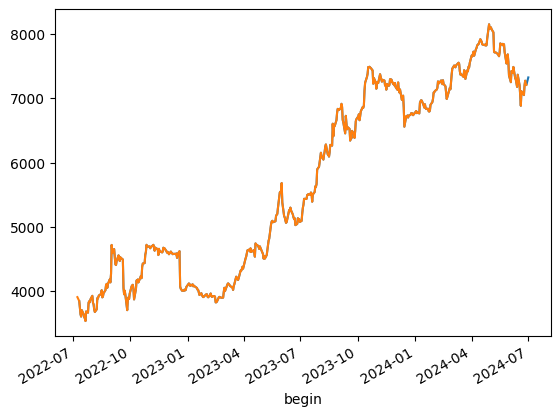

In [80]:
close_vec.loc[dates].plot()
close_vec.loc[prev_dates].plot()

In [81]:
prev_close = close_vec.loc[prev_dates[-len(y_test):]]

closes = {}

for model in results_df.model.values:
    closes[model] = (([res.predicted_vec for res in results if res.model_name == model][0] + 1) * prev_close).values

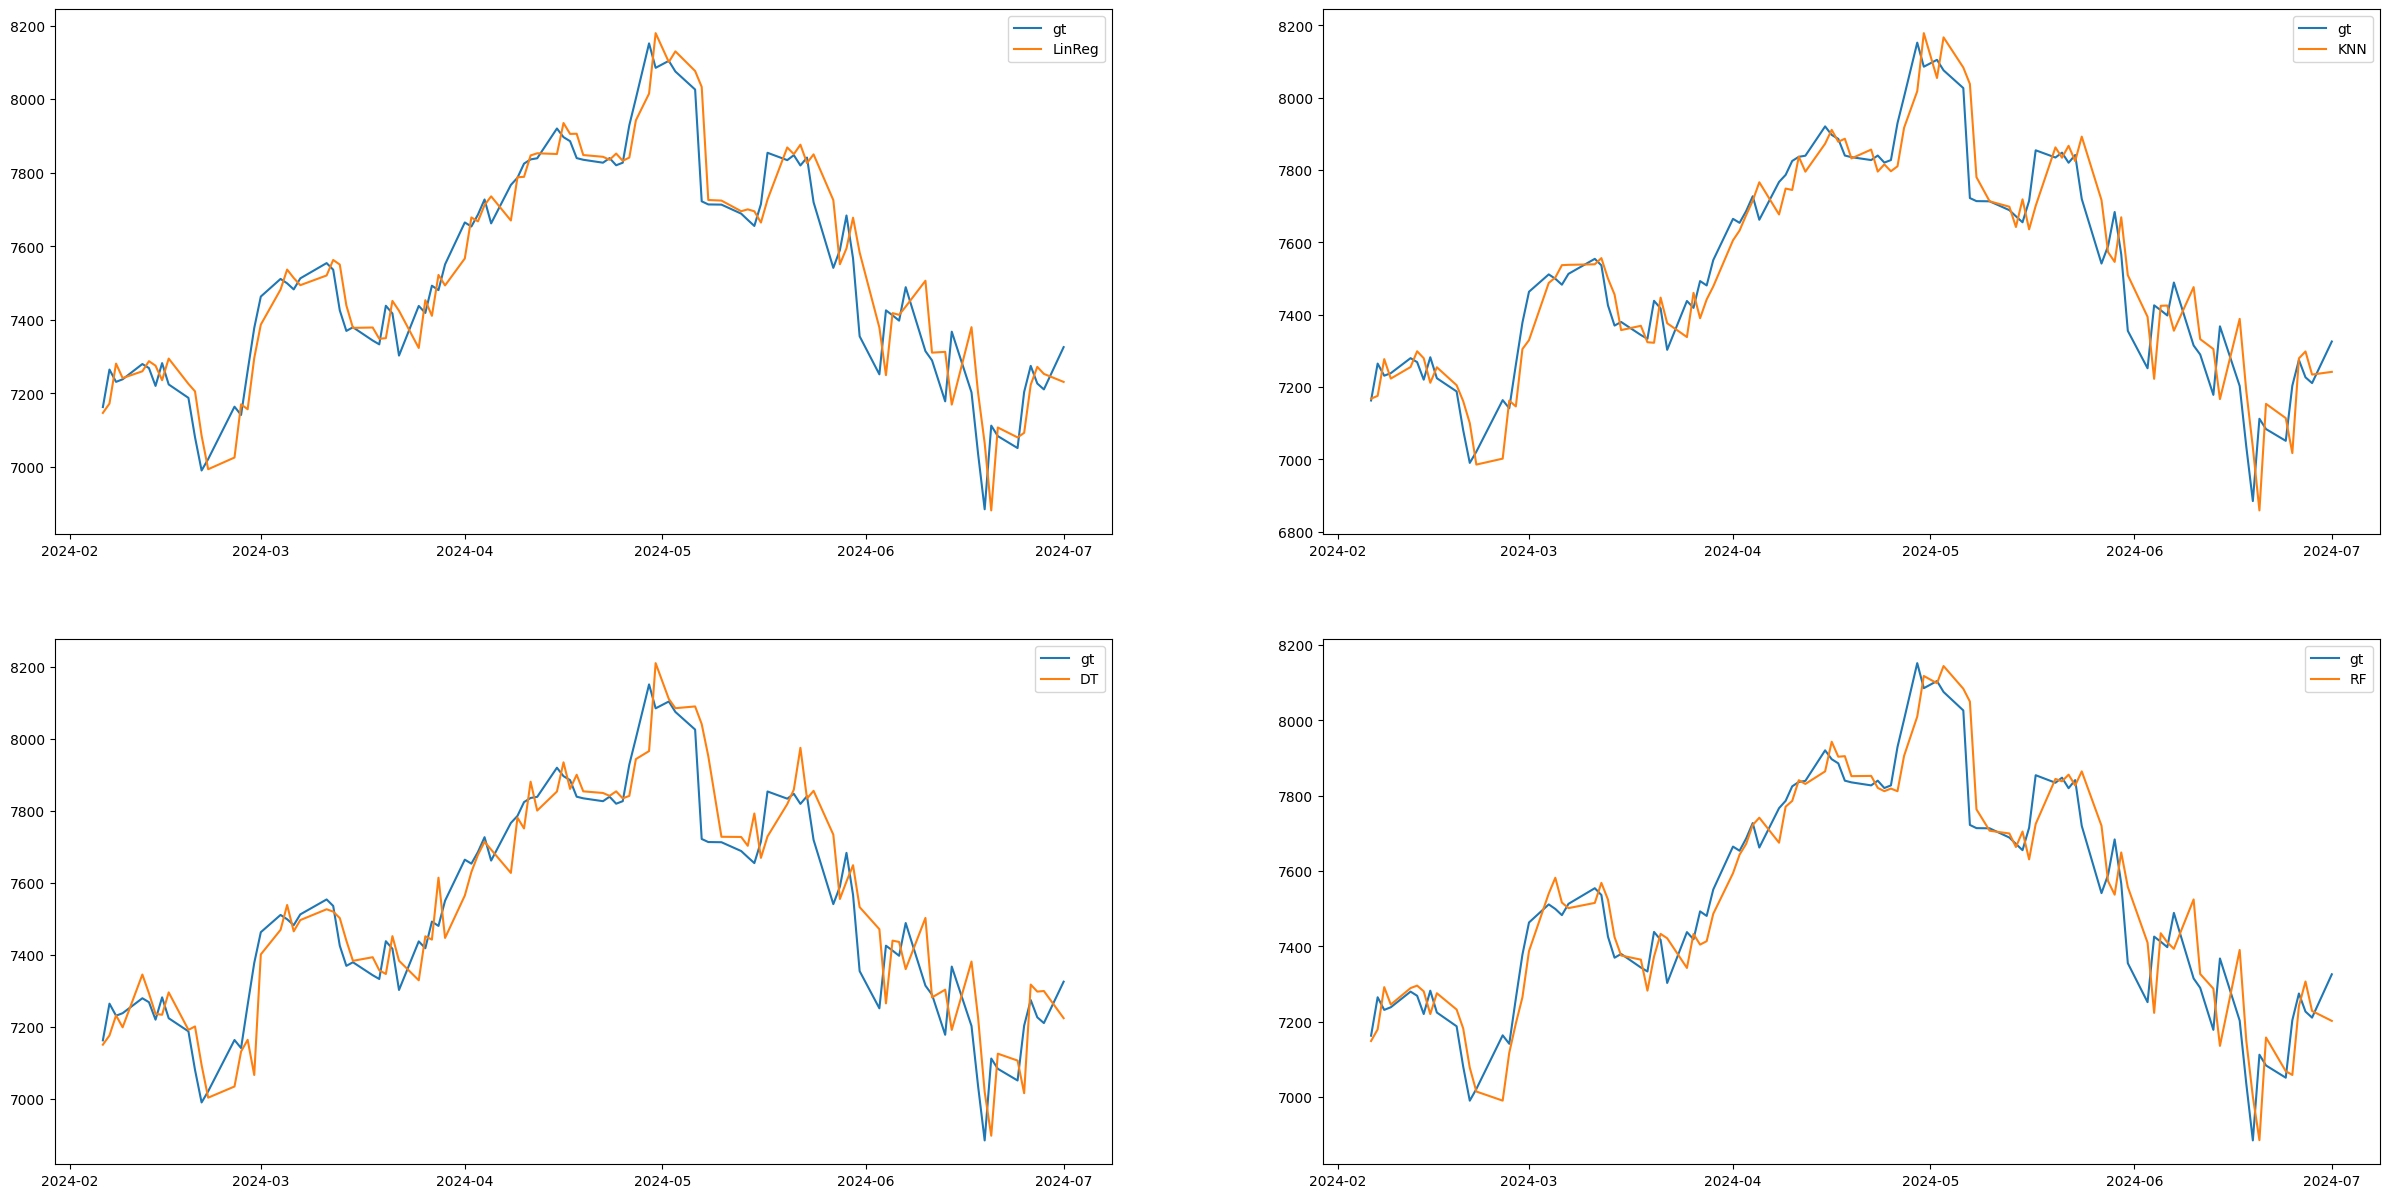

In [146]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 15))

for idx, model in enumerate(results_df.model.values):
    axs[idx//2, idx % 2].plot(dates[-len(y_pred):], close_vec.loc[dates[-len(y_test):]].values, label='gt')
    axs[idx//2, idx % 2].plot(dates[-len(y_pred):], closes[model], label = model)
    axs[idx//2, idx % 2].legend()
    
plt.show()

In [76]:
df = pd.Dataframe({'models': })

SyntaxError: expression expected after dictionary key and ':' (499493488.py, line 1)

In [83]:
def accuracy_for_regr(y_pred: np.ndarray, y_test: np.ndarray, miss_percent: int):
    difference = np.abs(y_pred - y_test) / y_test
    ratio = np.where(difference <= miss_percent / 100, 1, 0).sum() / len(difference)
    return ratio

In [84]:
new_df = pd.DataFrame(columns = ['model', 'mse', 'mape', '1%', '5%', '10%'])

y_close_true = close_vec.loc[dates[-len(x_test):]].values

for model in results_df.model.values:
    y_close_pred = ([res.predicted_vec for res in results if res.model_name == model][0] + 1) * prev_close
    
    if new_df.empty:
        new_df = pd.DataFrame({'model': [model],
                               'mse': mean_squared_error(y_close_pred, y_close_true), 
                               'mape': mean_absolute_percentage_error(y_close_pred, y_close_true),
                               '0.1%': accuracy_for_regr(y_close_pred, y_close_true, 0.1),
                               '0.3%': accuracy_for_regr(y_close_pred, y_close_true, 0.3),
                               '0.5%': accuracy_for_regr(y_close_pred, y_close_true, 0.5),
                               '0.7%': accuracy_for_regr(y_close_pred, y_close_true, 0.7),
                               '1%': accuracy_for_regr(y_close_pred, y_close_true, 1),
                               '3%': accuracy_for_regr(y_close_pred, y_close_true, 3),
                              })
    else:
        new_df = pd.concat([pd.DataFrame({'model': [model],
                                          'mse': mean_squared_error(y_close_pred, y_close_true), 
                                          'mape': mean_absolute_percentage_error(y_close_pred, y_close_true),
                                          '0.1%': accuracy_for_regr(y_close_pred, y_close_true, 0.1),
                                           '0.3%': accuracy_for_regr(y_close_pred, y_close_true, 0.3),
                                           '0.5%': accuracy_for_regr(y_close_pred, y_close_true, 0.5),
                                           '0.7%': accuracy_for_regr(y_close_pred, y_close_true, 0.7),
                                           '1%': accuracy_for_regr(y_close_pred, y_close_true, 1),
                                           '3%': accuracy_for_regr(y_close_pred, y_close_true, 3)
                                         }), new_df])

In [85]:
new_df

,model,mse,mape,0.1%,0.3%,0.5%,0.7%,1%,3%
0,RF,8544.437279,0.009158,0.069307,0.306931,0.415842,0.485149,0.623762,0.970297
0,DT,10576.008659,0.010260,0.079208,0.237624,0.376238,0.495050,0.603960,0.950495
0,KNN,8876.095984,0.009613,0.069307,0.227723,0.376238,0.485149,0.613861,0.980198
0,LinReg,8110.274423,0.008981,0.089109,0.257426,0.435644,0.544554,0.653465,0.970297


In [148]:
new_df.to_csv(path_or_buf='./metrics_kotorie_pravilnie_esli_che.csv')

05.07.2024

In [86]:
lkoh_df = pd.DataFrame(data[ticker].close)
lkoh_df.dropna(inplace=True)

In [113]:
xx, yy = [], []

for sub_df in lkoh_df.rolling(window=6):
    if len(sub_df) < 6:
        continue
    xx.append(sub_df.close.values[:-1])
    yy.append(sub_df.close.values[-1])


In [114]:
x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(xx, yy, shuffle=False, test_size=0.2)

In [115]:
results_v = []

In [128]:
lr = LinearRegression()

lr.fit(x_train_v, y_train_v)

LinearRegression()

In [129]:
y_pred = lr.predict(x_test_v)

In [130]:
results_v.append(Results(model_name='LinReg',
                       model_params='',
                       ticker_name=ticker,
                       mse=mean_squared_error(y_pred, y_test_v),
                       accuracy=np.where(y_pred - y_test_v >= 0, 1, 0).sum() / len(y_test_v),
                       predicted_vec=y_pred))

In [131]:
best_model, best_k = ..., None

min_loss = 10**10

for k in range(3, 20, 3):
    _knn = KNeighborsRegressor(n_neighbors=k)
    _knn.fit(x_train_v, y_train_v)
    prediction = _knn.predict(x_test_v)
    loss = mean_squared_error(prediction, y_test_v)
    if loss < min_loss:
        best_model = _knn
        best_k = k
        min_loss = loss

In [132]:
knn_reg = best_model

prediction = knn_reg.predict(x_test)

results_v.append(Results(model_name='KNN',
                       model_params=f'k = {k}',
                       ticker_name=ticker,
                       mse = mean_squared_error(prediction, y_test_v),
                       accuracy=np.where(prediction - y_test_v >= 0, 1, 0).sum() / len(y_test_v),
                       predicted_vec=prediction
                      ))

In [133]:
depthes = [i for i in range(7, 40, 5)]
min_sample_leaf = [i for i in range(1, 7, 2)]
min_sample_split = [i for i in range(2, 9, 2)]

best_params = {}
min_loss = 10**10
best_model = ...

for depth in depthes:
    for leaf in min_sample_leaf:
        for split in min_sample_split:
            
            params = {'max_depth': depth,
                      'min_samples_leaf': leaf,
                      'min_samples_split': split,
                      'random_state': SEED
                     }
            
            _dt = DecisionTreeRegressor(**params)
            _dt.fit(x_train_v, y_train_v)
            prediction = _dt.predict(x_test_v)

            loss = mean_squared_error(prediction, y_test_v)

            if loss < min_loss:
                best_model = _dt
                best_params = params
                min_loss = loss

In [134]:
def accuracy_for_vanila_regression(y_pred, y_true):
    return np.where(y_pred - y_true >= 0, 1, 0).sum() / len(y_true)

In [135]:
dt_reg = best_model

prediction = dt_reg.predict(x_test_v)

results_v.append(Results(model_name='DT',
                       model_params=best_params,
                       ticker_name=ticker,
                       mse=mean_squared_error(prediction, y_test_v),
                       accuracy=accuracy_for_vanila_regression(prediction, y_test_v),
                       predicted_vec=prediction
                      ))

In [136]:
estimators = [30, 50, 70, 120]
depthes = [i for i in range(7, 40, 5)]
min_sample_leaf = [i for i in range(1, 7, 2)]
min_sample_split = [i for i in range(2, 9, 2)]

best_params = {}
min_loss = 10**10
best_model = ...

for depth in depthes:
    for leaf in min_sample_leaf:
        for split in min_sample_split:
            for estimator in estimators:
            
                params = {'max_depth': depth,
                          'min_samples_leaf': leaf,
                          'min_samples_split': split,
                          'n_estimators': estimator,
                          'random_state': SEED
                         }
                
                _rf = RandomForestRegressor(**params)
                _rf.fit(x_train_v, y_train_v)
                prediction = _rf.predict(x_test_v)
    
                loss = mean_squared_error(prediction, y_test_v)
    
                if loss < min_loss:
                    best_model = _rf
                    best_params = params
                    min_loss = loss

In [137]:
rf_reg = best_model

prediction = rf_reg.predict(x_test_v)

results_v.append(Results(model_name='RF',
                       model_params=best_params,
                       ticker_name=ticker,
                       mse = mean_squared_error(prediction, y_test_v),
                       accuracy=accuracy_for_vanila_regression(prediction, y_test_v),
                       predicted_vec=prediction
                      ))

IndexError: index 2 is out of bounds for axis 0 with size 2

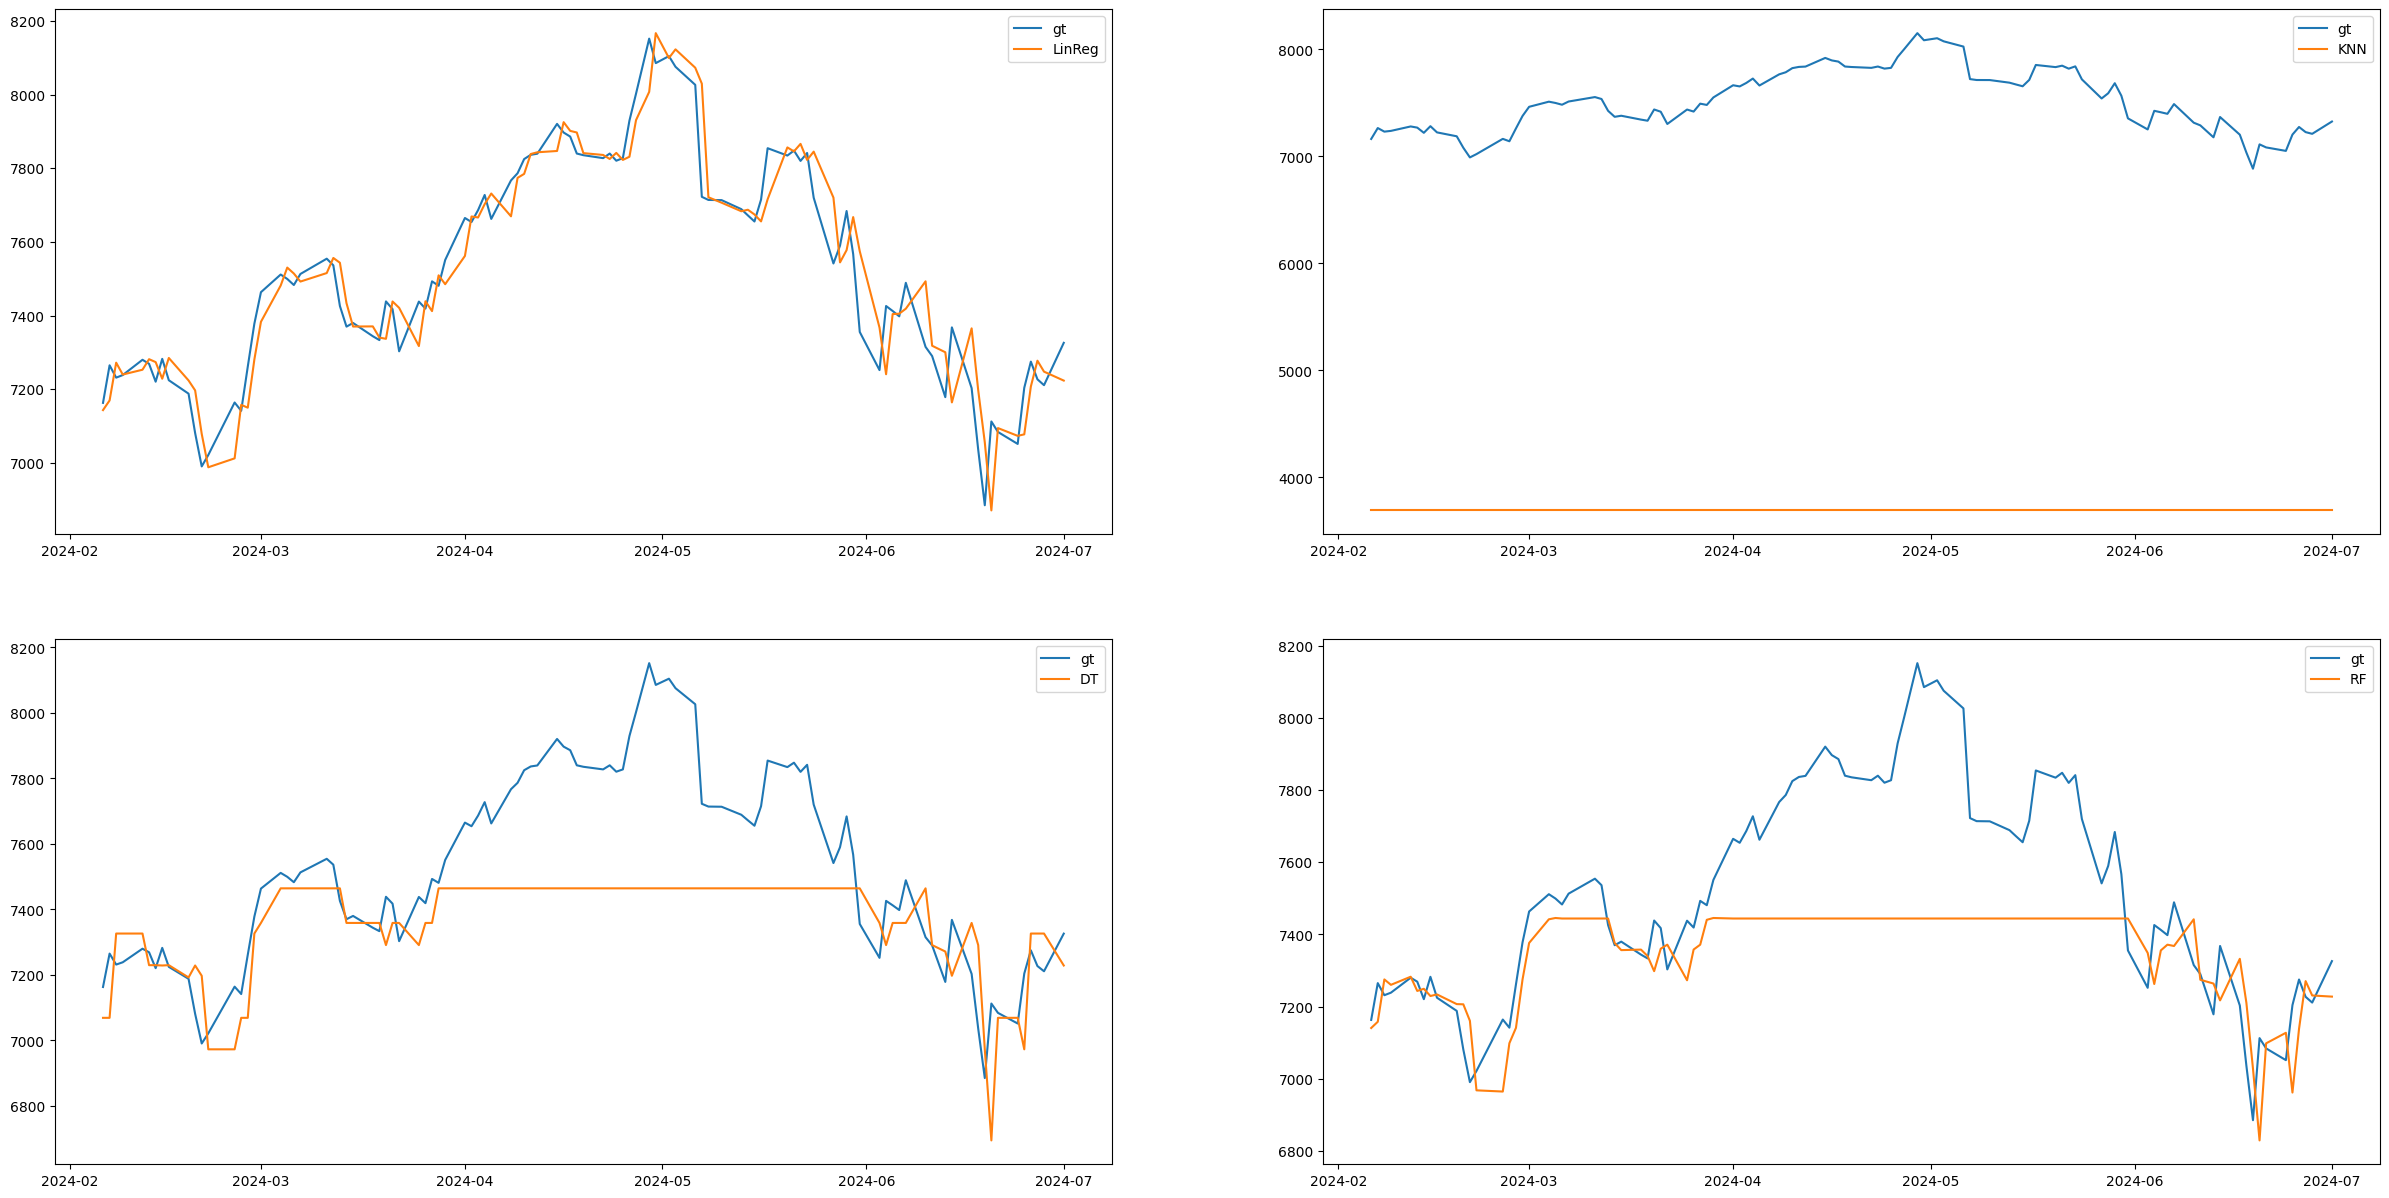

In [150]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 15))

for idx, model in enumerate([res.model_name for res in results]):
    axs[idx//2, idx % 2].plot(dates[-len(y_pred):], y_test_v, label='gt')
    axs[idx//2, idx % 2].plot(dates[-len(y_pred):], [res.predicted_vec for res in results_v if res.model_name == model][0], label = model)
    axs[idx//2, idx % 2].legend()
    
plt.show()

In [ ]:
class 